# **Siamese LSTM model for resume and job description matching.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Preprocessing

## Tensorflow version downgrade for compatibility with keras

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
Y
  Successfully uninstalled tensorflow-2.17.0


In [ ]:
!pip install tensorflow==2.15.0

## Install required libraries

In [ ]:
# Install required libraries
import scipy as sc
from scipy.spatial.distance import cosine
import pandas as pd
import math
import logging
from collections import Counter
from tqdm import tqdm
from tabulate import tabulate

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelBinarizer

import os
import re
import nltk
from nltk.tokenize import word_tokenize as wt
from nltk.tokenize import sent_tokenize as st
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import matplotlib.pyplot as plt

import keras
from keras.preprocessing.sequence import pad_sequences
from keras import backend as k
from keras import initializers
from keras.optimizers import RMSprop, Adam, Adagrad
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, LSTM, Input, Activation, Flatten, subtract, concatenate, Reshape, Embedding, Bidirectional, Dropout
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Dataset

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/DL Project/Code/train.csv', encoding='latin-1', on_bad_lines='skip')

# Remove missing values
print("Number of examples: %s" % len(data))
data = data.dropna(subset=['resume', 'job_description', 'is_fit'])
data = data.reset_index(drop=True)
print("Number of examples after removing NA: %s" % len(data))

Number of examples: 4685
Number of examples after removing NA: 4685


Summary statistics for the length of resumes and job descriptions

In [ ]:
# Define a function to calculate the number of words in a string
def word_count(text):
    return len(text.split())

# Apply the word_count function to calculate the length of each resume and job description
data['resume_length'] = data['resume'].apply(word_count)
data['job_description_length'] = data['job_description'].apply(word_count)

# Calculate summary statistics for resume and job description lengths
resume_stats = data['resume_length'].describe()
job_description_stats = data['job_description_length'].describe()

# Print the summary statistics
print("Resume Length Summary Statistics:")
print(resume_stats)
print("\nJob Description Length Summary Statistics:")
print(job_description_stats)


Resume Length Summary Statistics:
count    4685.000000
mean      706.810459
std       393.580612
min        84.000000
25%       487.000000
50%       619.000000
75%       810.000000
max      3134.000000
Name: resume_length, dtype: float64

Job Description Length Summary Statistics:
count    4685.000000
mean      375.136820
std       237.136455
min        11.000000
25%       171.000000
50%       330.000000
75%       532.000000
max      1079.000000
Name: job_description_length, dtype: float64


Constants

In [ ]:
STRING_SIZE = 375  # We chose the maxlen as 375, which is the mean of the length of job descriptions
BATCH_SIZE = 64
NUM_EPOCHS = 50


## Thread-Safe Data Generators

This generator handles batches for single and two-input networks.

In [ ]:
import threading
import numpy as np

class ThreadsafeIter:
    """A thread-safe iterator to serialize access to the generator."""
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)

def threadsafe_generator(f):
    """Decorator that makes a generator function thread-safe."""
    def g(*a, **kw):
        return ThreadsafeIter(f(*a, **kw))
    return g

@threadsafe_generator
def get_samples(x, y, batch_size, max_len=375):
    """Generator for single input model (e.g. one sequence input)."""
    sizeX = len(x)
    while True:
        try:
            index = np.random.randint(0, sizeX, size=batch_size)
            examples = x[index]
            examples = pad_sequences(examples, maxlen=max_len, padding='post')
            labels = y[index]
            yield (examples, labels)
        except Exception as e:
            print(f"Error in get_samples: {e}")
            break

@threadsafe_generator
def get_samples_2_inputs(x1, x2, y, batch_size, max_len=375):
    """Generator for siamese LSTM model (e.g. two input sequences)."""
    sizeX = len(x1)
    while True:
        try:
            index = np.random.randint(0, sizeX, size=batch_size)
            examples1 = pad_sequences(x1[index], maxlen=max_len, padding='post')
            examples2 = pad_sequences(x2[index], maxlen=max_len, padding='post')
            labels = y[index]
            yield [[examples1, examples2], labels]
        except Exception as e:
            print(f"Error in get_samples_2_inputs: {e}")
            break

# Example usage:
# train_gen = get_samples(sentence1_list, binary_similarity_class, 32)
# siamese_gen = get_samples_2_inputs(resume_list, job_desc_list, binary_similarity_class, 32)

## Using Fuction: Remove Special Characters and Stopword, Handle Contractions, and Tokenize Words.

In [ ]:
def remove_special(text):
    special_chars_pattern = "[~#$%^@&*()+_\",?!.:;><`|{}=\\']"
    text = re.sub(special_chars_pattern, " ", text)
    return text.strip()

def contractions(sent):
    sub_pattern = [("will not","won't"),("shall not","shan't"),
                (" not", "n\'t"),(" will","\'ll"),(" is","\'s"),
                   (" am","\'m"),(" are","\'re"),(" is","who\'s")]
    sent2=sent.split(" ")
    hold = ""
    for k in range(len(sent2)):
        kk = sent2[k]
        for rep in range(len(sub_pattern)):
            kk = re.sub(sub_pattern[rep][1],sub_pattern[rep][0],kk)
        hold = hold + " " + kk
    return hold.lower()

def remove_stop_words(text):
    stops =  set(stopwords.words('english'))
    stops1 = [word.lower() for word in stops]
    punctuation = [',','.','!','?',';','-']
    hold = []
    if type(text) == list:
        for word in range(len(text)):
            if text[word].lower() in stops1 or text[word].lower() in punctuation or text[word].lower() == "xxxxxx":
                continue
            else:
                hold.append(text[word].lower())
    return hold

def wordTok(sent): # Word Tokenizer
    tok = wt(sent)
    return tok

def pipeline(text):
    text = contractions(text)
    text = remove_special(text)
    textToks = wordTok(text)
    textToks = remove_stop_words(textToks)
    final = ""
    for k in range(len(textToks)):
            final = final+textToks[k]+" "
    return final.strip().lower()

In [ ]:
# Apply the pipeline function to 'resume' and 'job_description' columns
data['resume'] = data['resume'].apply(pipeline)
data['job_description'] = data['job_description'].apply(pipeline)

In [ ]:
# Display some information after preprocessing
import numpy as np
print("\n")
print(data.head(2))
print("\n")
print(data.tail(2))
print("\n")
print("Proportion of positives: %s" % np.mean(data["is_fit"]))



                                              resume  \
0  summaryhighly motivated sales associate extens...   
1  professional summarycurrently working caterpil...   

                                     job_description  is_fit  resume_length  \
0  net2source inc award-winning total workforce s...       0            794   
1  salas obrien tell clients engineered impact pa...       0            863   

   job_description_length  
0                     559  
1                     568  


                                                 resume  \
4683  profileability prioritize multi-task environme...   
4684  summaryfull stack software engineer 8 years ex...   

                                        job_description  is_fit  \
4683  client growing medical device company located ...       1   
4684  robert half looking senior full stack engineer...       1   

      resume_length  job_description_length  
4683            726                     214  
4684            662              

## Using Fuction: Create Corpus and word vectors (Word2Vec)

In [ ]:
def createCorpus(t):
    corpus = []
    all_sent = []
    for k in t:
        for p in t[k]:
            corpus.append(st(p)) # st: sentence tokenizer
    for sent in range(len(corpus)):
        for k in corpus[sent]:
            all_sent.append(k)
    for m in range(len(all_sent)):
        all_sent[m] = wt(all_sent[m]) # wt: word tokenizer

    all_words=[]
    for sent in all_sent:
        hold=[]
        for word in sent:
            hold.append(word.lower())
        all_words.append(hold)
    return all_words

def wordvecmatrix(model1,data):
    IO_data={"resume":[],"job_description":[],"label":[]}
    pbar = tqdm(range(len(data["resume"])))
    for k in range(len(data["job_description"])):
        resume=[]
        job_description=[]
        label=[]
        for word in data["resume"][k]:
            try:
                resume.append(model1.wv.get_vector(word))
            except Exception as e:
                continue
        for word in data["job_description"][k]:
            try:
                job_description.append(model1.wv.get_vector(word))
            except Exception as e:
                continue
        IO_data["label"].append(data["is_fit"][k])
        IO_data["resume"].append(resume)
        IO_data["job_description"].append(job_description)
        pbar.update(1)
    print('\007')
    pbar.close()
    return IO_data

def sequence_padding(stringlist):
    newstring = pad_sequences(stringlist, maxlen=STRING_SIZE,
                              dtype=object,padding='post',value="PAD")
    return newstring

def list2string(listinput):
    hold=""
    for k in listinput:
        hold = hold +k.strip()+" "
    return hold.strip()

Apply word tokenization to Resumes and Job Descriptions

In [ ]:
# Word Tokenzation in each resume and job description
sentences1 = list(map(wordTok,data["resume"]))
sentences2 = list(map(wordTok,data["job_description"]))

#Truncade and Pad to N words max
sentences1 = list(map(list,sequence_padding(sentences1)))
sentences2 = list(map(list,sequence_padding(sentences2)))

# Update resumes and job descriptions with the same length
data["resume"] = sentences1
data["job_description"] = sentences2
dataAll = [data["resume"],data["job_description"]]
dataAll = pd.concat(dataAll)
dataAll.head()

,0
0,"[suwanee, pointe, drivelawrenceville, ga, 3004..."
1,"[test, groups, various, plants, discuss, solve..."
2,"[tasks, adhered, company, standards, osha, reg..."
3,"[installation, husky, cable, tray, 1000, kcmil..."
4,"[running, edw, reports, crystal, reports, deep..."


Apply Word2Vec word embedding to the combined dataset of tokenized and padded resumes and job descriptions

In [ ]:
# Word2Vec model
embedding_model = Word2Vec(vector_size=128, sg=1, compute_loss=False, window=4, min_count=1, workers=8)

embedding_model.build_vocab(dataAll)  # prepare the model vocabulary
embedding_model.train(dataAll, total_examples=embedding_model.corpus_count, queue_factor=6, epochs=40)
embedding_model.save("/content/drive/My Drive/DL Project/Code/word2vec_256.model")

final_data = wordvecmatrix(embedding_model, data)
print(sentences1[2])
print(len(final_data["resume"][2]))
print(sentences2[2])
print(len(final_data["job_description"][2]))
del dataAll


100%|██████████| 4685/4685 [00:03<00:00, 1495.14it/s]


['tasks', 'adhered', 'company', 'standards', 'osha', 'regulations', 'work', 'site', 'safety', 'completed', 'semi-skilled', 'skilled', 'work', 'supervision', 'fully', 'qualified', 'supervisors', 'assisted', 'electrical', 'installation', 'tasks', 'added', 'new', 'wiring', 'adjusted', 'breaker', 'boxes', 'examined', 'tested', 'electrical', 'systems', 'locate', 'loose', 'connections', 'faults', 'make', 'proactive', 'repairs', 'collaborated', 'knowledgeable', 'professionals', 'grow', 'understanding', 'principles', 'construction', 'standards', 'inspected', 'existing', 'wiring', 'identify', 'short', 'circuits', 'kept', 'work', 'areas', 'clean', 'neat', 'organized', 'efficient', 'operations', 'utilized', 'knowledge', 'equipment', 'test', 'wiring', 'system', 'parts', 'electrical', 'flow', 'function', 'resolved', 'issues', 'existing', 'systems', 'replaced', 'malfunctioning', 'parts', '08/2014to06/2017dog', 'handlertrugreen', '\x80', 'cambridge', 'springs', 'pa', 'developed', 'long-term', 'rela

Show a list of word vectors for resume and job description indiviaully.


In [ ]:
print(pd.DataFrame(final_data).head(5))
print("\n")

                                              resume  \
0  [[0.37195548, -0.14503175, -0.48988777, 0.6144...   
1  [[-0.19781202, 0.17102301, -0.78062665, 0.3882...   
2  [[0.47706848, 0.7634326, -0.21703589, 0.284227...   
3  [[-0.034802437, 0.25666544, -0.77718735, -0.17...   
4  [[-0.42291793, -0.043930322, 0.091778666, 0.30...   

                                     job_description  label  
0  [[0.5885101, -0.82983285, -1.2875283, -0.15676...      0  
1  [[0.30905908, 0.07539118, -0.31950772, -0.0065...      0  
2  [[0.1641753, 0.31095523, -0.2551826, -0.286517...      0  
3  [[-0.2265156, -0.51999307, -0.9432176, -0.2480...      0  
4  [[-0.63015735, -0.5408862, -0.0871741, -1.1328...      0  




Cosine Similarity for the first pair of resume and job description

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to average the word vectors of a document
def average_word_vectors(word_vectors):
    return np.mean(word_vectors, axis=0)

# Get the word vectors for resume[0] and job_description[0]
resume_vectors = np.array(final_data["resume"][0])
job_description_vectors = np.array(final_data["job_description"][0])

# Calculate the average word vector for both the resume and the job description
avg_resume_vector = average_word_vectors(resume_vectors)
avg_job_description_vector = average_word_vectors(job_description_vectors)

# Compute cosine similarity between the averaged vectors
similarity = cosine_similarity([avg_resume_vector], [avg_job_description_vector])

# Print the cosine similarity
print(f"Cosine Similarity between resume[0] and job_description[0]: {similarity[0][0]}")

Cosine Similarity between resume[0] and job_description[0]: 0.8477902412414551


# 2. Split the dataset into training and validation sets

In [ ]:
import numpy as np


#split=int(0.8*len(final_data["label"]))
y = final_data["label"]
x1_train,x1_val,x2_train,x2_val,y_train,y_val = tts(final_data["resume"], # tts: train_test_split
                                                    final_data["job_description"],
                                                    y,test_size=0.2)

x1_train = np.array(x1_train,dtype='float32')
x1_val = np.array(x1_val,dtype='float32')
x2_train = np.array(x2_train,dtype='float32')
x2_val = np.array(x2_val,dtype='float32')
y_train = np.array(y_train,dtype='float32')
y_val = np.array(y_val,dtype='float32')


TRAIN_SIZE = len(x1_train)
VAL_SIZE = len(x1_val)

# Print data shapes for verification
print(x1_train.shape, x1_val.shape, x2_train.shape, x2_val.shape, y_train.shape, y_val.shape)

(3748, 375, 128) (937, 375, 128) (3748, 375, 128) (937, 375, 128) (3748,) (937,)


In [ ]:
from keras.utils import Sequence

class MyDataGenerator(Sequence):
    def __init__(self, x1, x2, y, batch_size):
        self.x1 = np.array(x1, dtype='float32')  # Ensure NumPy arrays
        self.x2 = np.array(x2, dtype='float32')  # Ensure NumPy arrays
        self.y = np.array(y, dtype='float32')    # Ensure NumPy arrays
        self.batch_size = batch_size

    def __len__(self):
        # Returns the number of batches per epoch
        return int(np.floor(len(self.x1) / self.batch_size))

    def __getitem__(self, index):
        # Generates a batch of data
        x1_batch = self.x1[index * self.batch_size:(index + 1) * self.batch_size]
        x2_batch = self.x2[index * self.batch_size:(index + 1) * self.batch_size]
        y_batch = self.y[index * self.batch_size:(index + 1) * self.batch_size]

        # Ensure the return is a tuple of numpy arrays, not lists
        return (np.array(x1_batch), np.array(x2_batch)), np.array(y_batch)

gentrain = MyDataGenerator(x1_train, x2_train, y_train, BATCH_SIZE)
gentest = MyDataGenerator(x1_val, x2_val, y_val, BATCH_SIZE)

In [ ]:
# Check a few batches from gentest
for i, batch in enumerate(gentest):
    print(f"Batch {i} from validation generator: {batch}")
    if i == 2:  # Check a few batches
        break

Batch 0 from validation generator: ((array([[[-0.28388274, -0.67196506, -0.68124956, ...,  0.06111545,
          0.76968163,  0.35343358],
        [-0.16706862, -0.3900683 , -0.25343478, ..., -0.11038448,
         -0.30565205,  0.59150255],
        [-0.91795725, -1.170284  ,  0.3101754 , ..., -0.54453963,
         -1.3463271 , -1.891282  ],
        ...,
        [-0.21822287, -0.24190706, -0.7191505 , ..., -0.55792564,
         -0.4454438 ,  0.558455  ],
        [-0.21822287, -0.24190706, -0.7191505 , ..., -0.55792564,
         -0.4454438 ,  0.558455  ],
        [-0.21822287, -0.24190706, -0.7191505 , ..., -0.55792564,
         -0.4454438 ,  0.558455  ]],

       [[-0.20648006, -1.1688794 , -0.16961218, ..., -1.2815557 ,
          0.12397329,  0.07433058],
        [-0.6792482 , -0.54905856, -1.9017776 , ..., -1.2938768 ,
         -0.35908428,  1.1600839 ],
        [-0.39164627, -0.38962087, -1.7448264 , ..., -1.9719596 ,
         -0.60545737,  1.4142329 ],
        ...,
        [-0.27731

Results of the embedding are returned as a list of sentences and their token embeddings, so each sentence is of the form<br>
__(sentence,embeddings for each word)__

# 3. Build numerous LSTM models and Find the best one!

## First Model: Siamese LSTM Model

In [ ]:
# For adjusting the learning rate
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 3
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [ ]:
model1_input = Input(shape=(x1_train.shape[1],x1_train.shape[2]),name="input1")
model1_LSTM = LSTM(128,return_sequences=False,
                   dropout=0.45,recurrent_dropout=0.1,name="LSTM1")(model1_input)
model1 = Model(model1_input,model1_LSTM)

model2_input = Input(shape=(x2_train.shape[1],x2_train.shape[2]),name='input2')
model2_LSTM = LSTM(128,return_sequences=False,
                   dropout=0.45,recurrent_dropout=0.1,name="LSTM2")(model2_input)
model2 = Model(model2_input,model2_LSTM)

merged = subtract([model1_LSTM,model2_LSTM],name="merge")

Dense_merged1 = Dense(64,activation="relu",name="dense1")(merged)
model_merged_out = Dense(1,activation="sigmoid",name="output")(Dense_merged1)

model=Model([model1_input,model2_input],model_merged_out)

adam = Adam(learning_rate=0.0001, clipvalue=1.0)
model.compile(adam, loss ='binary_crossentropy', metrics=['accuracy'])

lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
callbacks_list = [lrate,earlystopper]
model.fit([x1_train[:400],x2_train[:400]], y_train[:400],
          epochs=1,
          verbose=1,
          batch_size=BATCH_SIZE,
          validation_split=0.15,
          callbacks=callbacks_list)
model.summary()

6/6 [==============================] - 24s 3s/step - loss: 0.6643 - accuracy: 0.6206 - val_loss: 0.5928 - val_accuracy: 0.7333 - lr: 0.0010
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 375, 128)]           0         []                            
                                                                                                  
 input2 (InputLayer)         [(None, 375, 128)]           0         []                            
                                                                                                  
 LSTM1 (LSTM)                (None, 128)                  131584    ['input1[0][0]']              
                                                                                                  
 LSTM2 (LSTM)                (None, 128)           

In [ ]:
model.fit(
    gentrain,
    steps_per_epoch= TRAIN_SIZE // BATCH_SIZE,
    validation_data=([x1_val, x2_val], y_val),  # Direct validation data
    validation_steps=None,  # Not needed when using direct data
    epochs=NUM_EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)


# Save the model
model.save('/content/drive/My Drive/DL Project/Code/model.h5')

Epoch 1/50
 58/117 [=============>................] - ETA: 28s - loss: 0.5899 - accuracy: 0.6934

117/117 [==============================] - 31s 263ms/step - loss: 0.5899 - accuracy: 0.6934 - val_loss: 0.5880 - val_accuracy: 0.6937 - lr: 0.0010


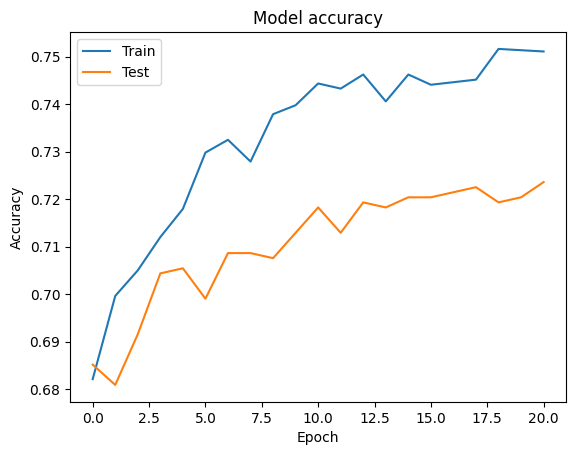

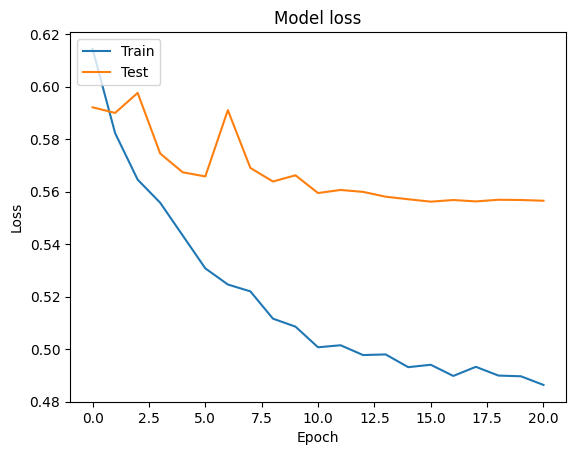

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Second Model: Simple LSTM Model

Concatenation: The two LSTM outputs are concatenated instead of performing subtraction (as was done in the Siamese LSTM model). This makes the model simpler because it doesn't explicitly model the difference between the two inputs.

In [ ]:
from keras.layers import LSTM, Dense, Input, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping
import math

# Step decay learning rate scheduler (same as used before)
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 3
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# Input layers for both resume and job description
resume_input = Input(shape=(x1_train.shape[1], x1_train.shape[2]), name="resume_input")
job_description_input = Input(shape=(x2_train.shape[1], x2_train.shape[2]), name="job_description_input")

# LSTM layers for each input
resume_LSTM = LSTM(128, return_sequences=False, dropout=0.45, recurrent_dropout=0.1, name="resume_LSTM")(resume_input)
job_description_LSTM = LSTM(128, return_sequences=False, dropout=0.45, recurrent_dropout=0.1, name="job_description_LSTM")(job_description_input)

# Concatenate the two LSTM outputs instead of subtracting
merged = Concatenate(name="merge")([resume_LSTM, job_description_LSTM])

# Dense layer for classification
dense = Dense(64, activation='relu', name="dense")(merged)
output = Dense(1, activation='sigmoid', name="output")(dense)

# Create the model
simple_lstm_model = Model(inputs=[resume_input, job_description_input], outputs=output)

# Compile the model
adam = Adam(learning_rate=0.001, clipvalue=1.0)
simple_lstm_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate scheduler and early stopping
lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
callbacks_list = [lrate, earlystopper]

# Train the model
simple_lstm_model.fit([x1_train[:400], x2_train[:400]], y_train[:400],
                      epochs=1,
                      verbose=1,
                      batch_size=BATCH_SIZE,
                      validation_split=0.2,
                      callbacks=callbacks_list)

# Model summary
simple_lstm_model.summary()

5/5 [==============================] - 19s 2s/step - loss: 0.6596 - accuracy: 0.6625 - val_loss: 0.5837 - val_accuracy: 0.7500 - lr: 0.0010
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 resume_input (InputLayer)   [(None, 375, 128)]           0         []                            
                                                                                                  
 job_description_input (Inp  [(None, 375, 128)]           0         []                            
 utLayer)                                                                                         
                                                                                                  
 resume_LSTM (LSTM)          (None, 128)                  131584    ['resume_input[0][0]']        
                                                   

In [ ]:
simple_lstm_model.fit(
    gentrain,
    steps_per_epoch= TRAIN_SIZE // BATCH_SIZE,
    validation_data=([x1_val, x2_val], y_val),  # Direct validation data
    validation_steps=None,  # Not needed when using direct data
    epochs=NUM_EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)


# Save the model
simple_lstm_model.save('/content/drive/My Drive/DL Project/Code/Simple_LSTM_model.h5')

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Third Model: Bidirectional LSTM model

In [ ]:
# For adjusting the learning rate
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 3
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [ ]:
from keras.layers import Bidirectional
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler, EarlyStopping

# Adjusted LSTM model
model1_input = Input(shape=(x1_train.shape[1],x1_train.shape[2]),name="input1")
model2_input = Input(shape=(x2_train.shape[1],x2_train.shape[2]),name='input2')

model1_LSTM = Bidirectional(LSTM(256, return_sequences=False, dropout=0.45, recurrent_dropout=0.1, name="LSTM1"))(model1_input) # Bidirectional LSTM # unit number 128 -> 256
model2_LSTM = Bidirectional(LSTM(256, return_sequences=False, dropout=0.45, recurrent_dropout=0.1, name="LSTM2"))(model2_input) # Bidirectional LSTM # unit number 128 -> 256

merged = subtract([model1_LSTM, model2_LSTM], name="merge")

Dense_merged1 = Dense(64, activation="relu", kernel_regularizer=l2(0.001), name="dense1")(merged) # L2 Regularization (lr=0.001)
model_merged_out = Dense(1, activation="sigmoid", name="output")(Dense_merged1)

model = Model([model1_input, model2_input], model_merged_out)

adam = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(adam, loss="binary_crossentropy", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
callbacks_list = [lrate, earlystopper]

# Training the model
model.fit([x1_train[:400], x2_train[:400]], y_train[:400],
          epochs=1,
          verbose=1,
          batch_size=BATCH_SIZE,
          validation_split=0.20,
          callbacks=callbacks_list)

model.summary()

5/5 [==============================] - 22s 3s/step - loss: 0.8136 - accuracy: 0.5875 - val_loss: 0.7839 - val_accuracy: 0.6125 - lr: 0.0010
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 375, 128)]           0         []                            
                                                                                                  
 input2 (InputLayer)         [(None, 375, 128)]           0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 512)                  788480    ['input1[0][0]']              
 onal)                                                                                            
                                                     

In [ ]:
model.fit(
    gentrain,
    steps_per_epoch= TRAIN_SIZE // BATCH_SIZE,
    validation_data=([x1_val, x2_val], y_val),  # Direct validation data
    validation_steps=None,  # Not needed when using direct data
    epochs=NUM_EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)


# Save the model
model.save('/content/drive/My Drive/DL Project/Code/Bidirectional_LSTM_model.h5')

Epoch 1/50
58/58 [==============================] - 171s 3s/step - loss: 0.6865 - accuracy: 0.6824 - val_loss: 0.5959 - val_accuracy: 0.7193 - lr: 0.0010
Epoch 2/50
58/58 [==============================] - 165s 3s/step - loss: 0.5504 - accuracy: 0.7427 - val_loss: 0.5114 - val_accuracy: 0.7599 - lr: 0.0010
Epoch 3/50
58/58 [==============================] - 164s 3s/step - loss: 0.4698 - accuracy: 0.7918 - val_loss: 0.4523 - val_accuracy: 0.8100 - lr: 5.0000e-04
Epoch 4/50
58/58 [==============================] - 163s 3s/step - loss: 0.4326 - accuracy: 0.8093 - val_loss: 0.4314 - val_accuracy: 0.8196 - lr: 5.0000e-04
Epoch 5/50
58/58 [==============================] - 163s 3s/step - loss: 0.4020 - accuracy: 0.8265 - val_loss: 0.4066 - val_accuracy: 0.8164 - lr: 5.0000e-04
Epoch 6/50
58/58 [==============================] - 162s 3s/step - loss: 0.3592 - accuracy: 0.8524 - val_loss: 0.4035 - val_accuracy: 0.8207 - lr: 2.5000e-04
Epoch 7/50
58/58 [==============================] - 163s 3s/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


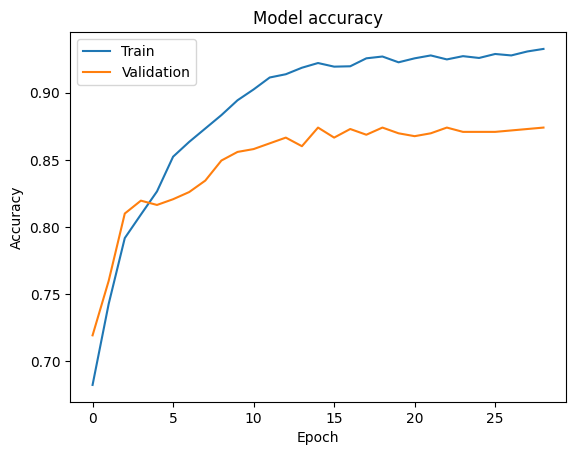

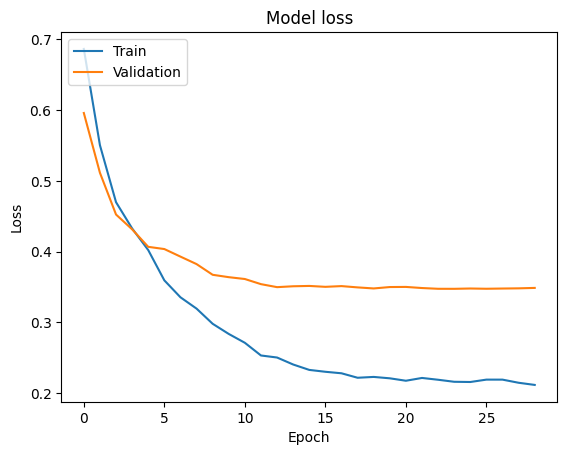

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 4. Testing

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/DL Project/Code/test.csv', encoding='latin-1', on_bad_lines='skip')
test_data =test_data.dropna(subset=['resume','job_description', 'is_fit'])
test_data =test_data.reset_index(drop=True)

# Apply the pipeline function to 'resume' and 'job_description' columns
test_data['resume'] = test_data['resume'].apply(pipeline)
test_data['job_description'] = test_data['job_description'].apply(pipeline)

sentences1 = list(map(wordTok,test_data["resume"]))
sentences2 = list(map(wordTok,test_data["job_description"]))

####Truncade and Pad to N words max
sentences1 = list(map(list,sequence_padding(sentences1)))
sentences2 = list(map(list,sequence_padding(sentences2)))

test_data["resume"] = sentences1
test_data["job_description"] = sentences2
test_dataAll = [test_data["resume"],test_data["job_description"]]
test_dataAll = pd.concat(test_dataAll)
test_dataAll.head()

,0
0,"[etl, mappings, usingssisandmetl, migrated, ex..."
1,"[professional, experience04/2018tocurrentsenio..."
2,"[keego, harbor, mi, sales, leads, signing, con..."
3,"[summarytyee, highlightsmicrosoft, excel, word..."
4,"[flexibility, maintainability, scalability, pe..."


In [ ]:
model2 = Word2Vec(vector_size = 128,sg=1,compute_loss=False,window=4,
                 min_count=1,workers=8)
model2.build_vocab(test_dataAll)  # prepare the model vocabulary
model2.train(test_dataAll, total_examples=model2.corpus_count,queue_factor=6, epochs=1)
model2.save("word2vec_64.model")
final_test_data = wordvecmatrix(model2,test_data)
del test_dataAll

100%|██████████| 1315/1315 [00:00<00:00, 1530.28it/s]




In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to average the word vectors of a document
def average_word_vectors(word_vectors):
    return np.mean(word_vectors, axis=0)

# Get the word vectors for resume[0] and job_description[0]
resume_vectors = np.array(final_test_data["resume"][0])
job_description_vectors = np.array(final_test_data["job_description"][0])

# Calculate the average word vector for both the resume and the job description
avg_resume_vector = average_word_vectors(resume_vectors)
avg_job_description_vector = average_word_vectors(job_description_vectors)

# Compute cosine similarity between the averaged vectors
similarity = cosine_similarity([avg_resume_vector], [avg_job_description_vector])

# Print the cosine similarity
print(f"Cosine Similarity between resume[0] and job_description[0]: {similarity[0][0]}")

Cosine Similarity between resume[0] and job_description[0]: 0.8591115474700928


In [ ]:
import numpy as np

y_test = final_test_data["label"]
x1_test,x2_test = final_test_data["resume"],final_test_data["job_description"]

x1_test = np.array(x1_test,dtype='float32')
x2_test = np.array(x2_test,dtype='float32')
y_test = np.array(y_test,dtype='float32')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 375, 128)]           0         []                            
                                                                                                  
 input2 (InputLayer)         [(None, 375, 128)]           0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 512)                  788480    ['input1[0][0]']              
 onal)                                                                                            
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 512)                  788480    ['input2[0][0]']          

In [ ]:
test_loss, test_accuracy = model.evaluate([x1_test, x2_test], y_test)

42/42 [==============================] - 15s 368ms/step - loss: 0.7434 - accuracy: 0.5452


In [ ]:
predictions = model.predict([x1_test, x2_test])
print(predictions)

42/42 [==============================] - 15s 346ms/step
[[0.23446128]
 [0.16551207]
 [0.18525952]
 ...
 [0.06904254]
 [0.7740213 ]
 [0.2361383 ]]


In [ ]:
predicted_labels = (predictions > 0.5).astype(int)
print(predicted_labels)

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


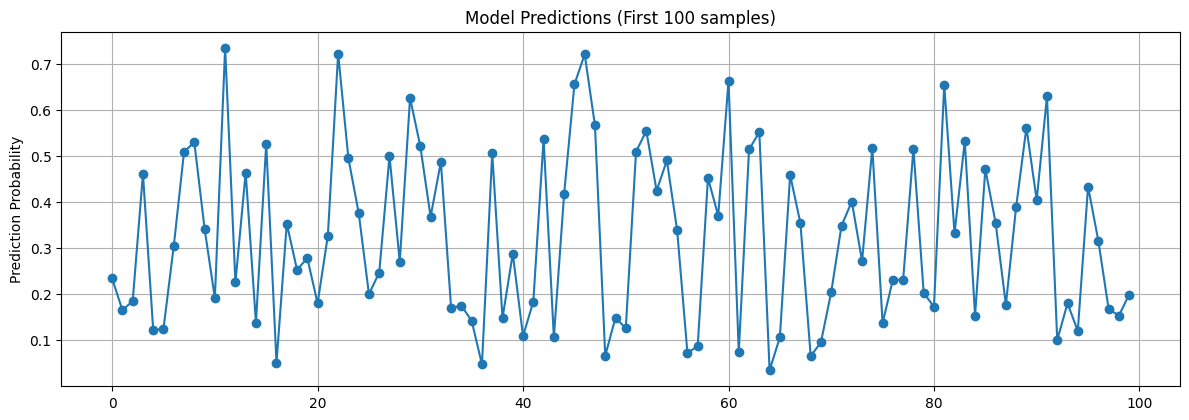

In [ ]:
plt.figure(figsize=(12, 8))

# Probability
plt.subplot(2, 1, 1)
plt.plot(predictions[:100], label="Predictions (Probability)", marker='o')
plt.ylabel("Prediction Probability")
plt.title("Model Predictions (First 100 samples)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
sample_size = 100


binary_labels = np.array(predicted_labels).flatten()[:sample_size]

df = pd.DataFrame({
    "Sample Index": np.arange(len(binary_labels))+1,
    "Predicted Label": binary_labels
})

df['Predicted Label'] = df['Predicted Label'].apply(lambda x: '✔' if x == 1 else '✘')

print(df.head(20))

    Sample Index Predicted Label
0              1               ✘
1              2               ✘
2              3               ✘
3              4               ✘
4              5               ✘
5              6               ✘
6              7               ✘
7              8               ✔
8              9               ✔
9             10               ✘
10            11               ✘
11            12               ✔
12            13               ✘
13            14               ✘
14            15               ✘
15            16               ✔
16            17               ✘
17            18               ✘
18            19               ✘
19            20               ✘
